# Scaffold Distribution Coverage Analysis

This notebook analyzes scaffold distribution coverage between:
- ChEMBL pretraining datasets (train/val/test_nomissing.csv)
- PKIS2 finetuning dataset (pkis2_finetuning.csv)

**Objectives:**
1. Scaffold overlap analysis between datasets
2. Chemical diversity assessment
3. Protein-specific coverage patterns
4. Transfer learning readiness evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdFingerprintGenerator, Draw
from rdkit.DataStructs import TanimotoSimilarity
from IPython.display import display, HTML

print("Libraries loaded successfully")

Libraries loaded successfully


## 1. Data Loading and Scaffold Extraction

In [2]:
def get_scaffold_smiles(smiles):
    """Extract Bemis-Murcko scaffold SMILES from molecule SMILES"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        if scaffold is None or scaffold.GetNumAtoms() == 0:
            return None
        return Chem.MolToSmiles(scaffold, isomericSmiles=False)
    except:
        return None

def load_dataset_with_scaffolds(filepath, dataset_name, smiles_col='smiles'):
    """Load dataset and extract scaffolds"""
    print(f"Loading {dataset_name}...")
    df = pd.read_csv(filepath)
    
    # Handle different SMILES column names
    if 'Smiles' in df.columns and 'smiles' not in df.columns:
        df = df.rename(columns={'Smiles': 'smiles'})
    
    print(f"  {len(df)} compounds loaded")
    
    # Extract scaffolds
    df['scaffold'] = df['smiles'].apply(get_scaffold_smiles)
    
    # Remove molecules without valid scaffolds
    valid_scaffolds = df['scaffold'].notna()
    df = df[valid_scaffolds].copy()
    
    print(f"  {len(df)} compounds with valid scaffolds")
    print(f"  {df['scaffold'].nunique()} unique scaffolds")
    
    df['dataset'] = dataset_name
    return df

# Load all datasets
datasets = {}
datasets['train'] = load_dataset_with_scaffolds(
    'datasets/chembl_pretraining_train_nomissing.csv', 'ChEMBL_Train'
)
datasets['val'] = load_dataset_with_scaffolds(
    'datasets/chembl_pretraining_val_nomissing.csv', 'ChEMBL_Val'
)
datasets['test'] = load_dataset_with_scaffolds(
    'datasets/chembl_pretraining_test_nomissing.csv', 'ChEMBL_Test'
)
datasets['pkis2'] = load_dataset_with_scaffolds(
    'datasets/pkis2_finetuning.csv', 'PKIS2_Finetuning'
)

print("\n=== Dataset Summary ===")
for name, df in datasets.items():
    print(f"{name:8}: {len(df):6} compounds, {df['scaffold'].nunique():5} scaffolds")

Loading ChEMBL_Train...
  59311 compounds loaded
  59311 compounds with valid scaffolds
  24749 unique scaffolds
Loading ChEMBL_Val...
  10467 compounds loaded
  10467 compounds with valid scaffolds
  3093 unique scaffolds
Loading ChEMBL_Test...
  9703 compounds loaded
  9703 compounds with valid scaffolds
  3093 unique scaffolds
Loading PKIS2_Finetuning...
  645 compounds loaded
  645 compounds with valid scaffolds
  369 unique scaffolds

=== Dataset Summary ===
train   :  59311 compounds, 24749 scaffolds
val     :  10467 compounds,  3093 scaffolds
test    :   9703 compounds,  3093 scaffolds
pkis2   :    645 compounds,   369 scaffolds


## 2. Scaffold Overlap Analysis

In [3]:
# Create scaffold sets for each dataset
scaffold_sets = {}
for name, df in datasets.items():
    scaffold_sets[name] = set(df['scaffold'].unique())

# All scaffolds across datasets
all_scaffolds = set()
for scaffolds in scaffold_sets.values():
    all_scaffolds.update(scaffolds)

print(f"Total unique scaffolds across all datasets: {len(all_scaffolds)}")

# Create scaffold presence matrix
scaffold_presence = {}
for scaffold in all_scaffolds:
    scaffold_presence[scaffold] = {
        name: scaffold in scaffold_sets[name] 
        for name in datasets.keys()
    }

presence_df = pd.DataFrame(scaffold_presence).T
presence_df = presence_df.astype(int)  # Convert boolean to int for easier analysis

print("\n=== Scaffold Presence Matrix ===")
print(presence_df.sum())

Total unique scaffolds across all datasets: 31097

=== Scaffold Presence Matrix ===
train    24749
val       3093
test      3093
pkis2      369
dtype: int64


In [4]:
# Compute pairwise overlaps
dataset_names = list(datasets.keys())
overlap_matrix = np.zeros((len(dataset_names), len(dataset_names)))
overlap_counts = np.zeros((len(dataset_names), len(dataset_names)))

for i, name1 in enumerate(dataset_names):
    for j, name2 in enumerate(dataset_names):
        set1 = scaffold_sets[name1]
        set2 = scaffold_sets[name2]
        
        if i == j:
            overlap_matrix[i, j] = 1.0
            overlap_counts[i, j] = len(set1)
        else:
            intersection = len(set1 & set2)
            union = len(set1 | set2)
            overlap_matrix[i, j] = intersection / union if union > 0 else 0
            overlap_counts[i, j] = intersection

# Create overlap dataframes
overlap_pct_df = pd.DataFrame(overlap_matrix, 
                             index=dataset_names, 
                             columns=dataset_names)
overlap_count_df = pd.DataFrame(overlap_counts, 
                               index=dataset_names, 
                               columns=dataset_names)

print("=== Scaffold Overlap (Jaccard Index) ===")
print(overlap_pct_df.round(3))
print("\n=== Scaffold Overlap (Absolute Counts) ===")
print(overlap_count_df.astype(int))

=== Scaffold Overlap (Jaccard Index) ===
       train    val   test  pkis2
train  1.000  0.000  0.000  0.005
val    0.000  1.000  0.000  0.013
test   0.000  0.000  1.000  0.013
pkis2  0.005  0.013  0.013  1.000

=== Scaffold Overlap (Absolute Counts) ===
       train   val  test  pkis2
train  24749     0     0    117
val        0  3093     0     45
test       0     0  3093     45
pkis2    117    45    45    369


In [5]:
# Key overlap statistics
chembl_all = scaffold_sets['train'] | scaffold_sets['val'] | scaffold_sets['test']
pkis2_scaffolds = scaffold_sets['pkis2']

chembl_pkis2_overlap = len(chembl_all & pkis2_scaffolds)
pkis2_unique = len(pkis2_scaffolds - chembl_all)
chembl_unique = len(chembl_all - pkis2_scaffolds)

print("\n=== ChEMBL vs PKIS2 Key Statistics ===")
print(f"ChEMBL total scaffolds: {len(chembl_all)}")
print(f"PKIS2 total scaffolds: {len(pkis2_scaffolds)}")
print(f"Shared scaffolds: {chembl_pkis2_overlap} ({chembl_pkis2_overlap/len(pkis2_scaffolds)*100:.1f}% of PKIS2)")
print(f"PKIS2 unique scaffolds: {pkis2_unique} ({pkis2_unique/len(pkis2_scaffolds)*100:.1f}% of PKIS2)")
print(f"ChEMBL unique scaffolds: {chembl_unique} ({chembl_unique/len(chembl_all)*100:.1f}% of ChEMBL)")

# Per-split overlap with PKIS2
print("\n=== PKIS2 Overlap by ChEMBL Split ===")
for split in ['train', 'val', 'test']:
    overlap = len(scaffold_sets[split] & pkis2_scaffolds)
    print(f"{split:5}: {overlap:4} scaffolds ({overlap/len(pkis2_scaffolds)*100:5.1f}% of PKIS2)")


=== ChEMBL vs PKIS2 Key Statistics ===
ChEMBL total scaffolds: 30935
PKIS2 total scaffolds: 369
Shared scaffolds: 207 (56.1% of PKIS2)
PKIS2 unique scaffolds: 162 (43.9% of PKIS2)
ChEMBL unique scaffolds: 30728 (99.3% of ChEMBL)

=== PKIS2 Overlap by ChEMBL Split ===
train:  117 scaffolds ( 31.7% of PKIS2)
val  :   45 scaffolds ( 12.2% of PKIS2)
test :   45 scaffolds ( 12.2% of PKIS2)


## 3. Chemical Diversity Analysis

In [6]:
def compute_tanimoto_similarity(smi1, smi2):
    """Compute Tanimoto similarity between two SMILES"""
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    
    if mol1 is None or mol2 is None:
        return 0.0
    
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
    fp1 = fpgen.GetFingerprint(mol1)
    fp2 = fpgen.GetFingerprint(mol2)
    
    return TanimotoSimilarity(fp1, fp2)

def sample_similarity_analysis(scaffolds1, scaffolds2, name1, name2, n_samples=1000):
    """Sample-based similarity analysis between two scaffold sets"""
    np.random.seed(42)
    
    # Sample pairs for analysis
    scaffolds1_list = list(scaffolds1)
    scaffolds2_list = list(scaffolds2)
    
    n_pairs = min(n_samples, len(scaffolds1_list) * len(scaffolds2_list))
    
    similarities = []
    for _ in range(n_pairs):
        s1 = np.random.choice(scaffolds1_list)
        s2 = np.random.choice(scaffolds2_list)
        sim = compute_tanimoto_similarity(s1, s2)
        similarities.append(sim)
    
    similarities = np.array(similarities)
    
    return {
        'mean': similarities.mean(),
        'median': np.median(similarities),
        'std': similarities.std(),
        'min': similarities.min(),
        'max': similarities.max(),
        'q75': np.percentile(similarities, 75),
        'q90': np.percentile(similarities, 90),
        'similarities': similarities
    }

print("Computing scaffold diversity analysis...")

# ChEMBL internal diversity (train vs val, train vs test)
diversity_results = {}

print("  ChEMBL train vs val...")
diversity_results['train_val'] = sample_similarity_analysis(
    scaffold_sets['train'], scaffold_sets['val'], 'train', 'val'
)

print("  ChEMBL train vs test...")
diversity_results['train_test'] = sample_similarity_analysis(
    scaffold_sets['train'], scaffold_sets['test'], 'train', 'test'
)

# ChEMBL vs PKIS2 diversity
print("  ChEMBL train vs PKIS2...")
diversity_results['train_pkis2'] = sample_similarity_analysis(
    scaffold_sets['train'], scaffold_sets['pkis2'], 'train', 'pkis2'
)

print("  ChEMBL (all) vs PKIS2...")
diversity_results['chembl_pkis2'] = sample_similarity_analysis(
    chembl_all, scaffold_sets['pkis2'], 'chembl_all', 'pkis2'
)

# Print summary
print("\n=== Scaffold Diversity Analysis (Tanimoto Similarity) ===")
print("Comparison              Mean    Median   Max    Q75    Q90")
print("-" * 55)
for name, result in diversity_results.items():
    print(f"{name:20} {result['mean']:.3f}   {result['median']:.3f}  {result['max']:.3f}  {result['q75']:.3f}  {result['q90']:.3f}")

Computing scaffold diversity analysis...
  ChEMBL train vs val...
  ChEMBL train vs test...
  ChEMBL train vs PKIS2...
  ChEMBL (all) vs PKIS2...

=== Scaffold Diversity Analysis (Tanimoto Similarity) ===
Comparison              Mean    Median   Max    Q75    Q90
-------------------------------------------------------
train_val            0.146   0.140  0.368  0.174  0.207
train_test           0.150   0.141  0.508  0.174  0.210
train_pkis2          0.152   0.146  0.400  0.178  0.219
chembl_pkis2         0.155   0.146  0.627  0.183  0.225


## 4. Protein-Specific Coverage Analysis

In [7]:
def get_protein_columns(df):
    """Extract protein column names (excluding smiles, scaffold, dataset)"""
    exclude_cols = {'smiles', 'scaffold', 'dataset', 'Smiles'}
    return [col for col in df.columns if col not in exclude_cols]

# Get protein columns for each dataset
protein_cols = {}
for name, df in datasets.items():
    protein_cols[name] = get_protein_columns(df)

print("=== Protein Column Counts ===")
for name, cols in protein_cols.items():
    print(f"{name:8}: {len(cols)} proteins")

# Find common proteins across datasets
chembl_proteins = set(protein_cols['train']) & set(protein_cols['val']) & set(protein_cols['test'])
pkis2_proteins = set(protein_cols['pkis2'])
common_proteins = chembl_proteins & pkis2_proteins

print(f"\nChEMBL proteins: {len(chembl_proteins)}")
print(f"PKIS2 proteins: {len(pkis2_proteins)}")
print(f"Common proteins: {len(common_proteins)}")
print(f"PKIS2 unique proteins: {len(pkis2_proteins - chembl_proteins)}")
print(f"ChEMBL unique proteins: {len(chembl_proteins - pkis2_proteins)}")

=== Protein Column Counts ===
train   : 332 proteins
val     : 332 proteins
test    : 332 proteins
pkis2   : 356 proteins

ChEMBL proteins: 332
PKIS2 proteins: 356
Common proteins: 331
PKIS2 unique proteins: 25
ChEMBL unique proteins: 1


In [8]:
def analyze_protein_scaffold_coverage(datasets_dict, protein_list, min_activity_threshold=6.5):
    """Analyze scaffold coverage per protein across datasets"""
    coverage_results = []
    
    for protein in protein_list:
        protein_data = {'protein': protein}
        
        for dataset_name, df in datasets_dict.items():
            if protein not in df.columns:
                protein_data[f'{dataset_name}_active_count'] = 0
                protein_data[f'{dataset_name}_scaffold_count'] = 0
                continue
            
            # Get active compounds for this protein
            active_mask = df[protein].notna() & (df[protein] >= min_activity_threshold)
            active_compounds = df[active_mask]
            
            protein_data[f'{dataset_name}_active_count'] = len(active_compounds)
            protein_data[f'{dataset_name}_scaffold_count'] = active_compounds['scaffold'].nunique()
        
        coverage_results.append(protein_data)
    
    return pd.DataFrame(coverage_results)

print("Analyzing protein-specific scaffold coverage (pChEMBL >= 6.5)...")

# Analyze coverage for common proteins
coverage_df = analyze_protein_scaffold_coverage(
    datasets, 
    list(common_proteins)[:50]  # Analyze first 50 common proteins for speed
)

# Compute ChEMBL total coverage (train + val + test)
chembl_combined = pd.concat([
    datasets['train'][['smiles', 'scaffold'] + list(common_proteins)],
    datasets['val'][['smiles', 'scaffold'] + list(common_proteins)],
    datasets['test'][['smiles', 'scaffold'] + list(common_proteins)]
], ignore_index=True)

chembl_coverage = analyze_protein_scaffold_coverage(
    {'chembl_all': chembl_combined}, 
    list(common_proteins)[:50]
)

# Merge results
final_coverage = coverage_df.merge(
    chembl_coverage[['protein', 'chembl_all_active_count', 'chembl_all_scaffold_count']],
    on='protein'
)

print(f"Coverage analysis completed for {len(final_coverage)} proteins")
print("\n=== Sample Coverage Results ===")
print(final_coverage[['protein', 'chembl_all_scaffold_count', 'pkis2_scaffold_count']].head(10))

Analyzing protein-specific scaffold coverage (pChEMBL >= 6.5)...
Coverage analysis completed for 50 proteins

=== Sample Coverage Results ===
  protein  chembl_all_scaffold_count  pkis2_scaffold_count
0   IGF1R                        422                    10
1    SGK3                          7                    12
2  CAMK2D                         55                     7
3   IRAK4                        696                    15
4    MST3                          6                    11
5   VPS34                         55                    29
6   CHEK2                        156                    18
7    ASK1                        133                     6
8    ULK3                          5                    25
9    PIM2                        579                    17


In [9]:
# Identify proteins with poor coverage
final_coverage['coverage_ratio'] = (
    final_coverage['pkis2_scaffold_count'] / 
    (final_coverage['chembl_all_scaffold_count'] + 1e-6)
)

# Proteins where PKIS2 has more diverse scaffolds than ChEMBL
high_pkis2_coverage = final_coverage[
    final_coverage['coverage_ratio'] > 1.0
].sort_values('coverage_ratio', ascending=False)

# Proteins where ChEMBL has much more diverse scaffolds
low_pkis2_coverage = final_coverage[
    (final_coverage['coverage_ratio'] < 0.3) & (final_coverage['chembl_all_scaffold_count'] > 5)
].sort_values('coverage_ratio')

print("=== Proteins with Higher PKIS2 Scaffold Diversity ===")
print(high_pkis2_coverage[['protein', 'chembl_all_scaffold_count', 'pkis2_scaffold_count', 'coverage_ratio']].head())

print("\n=== Proteins with Lower PKIS2 Scaffold Diversity ===")
print(low_pkis2_coverage[['protein', 'chembl_all_scaffold_count', 'pkis2_scaffold_count', 'coverage_ratio']].head())

=== Proteins with Higher PKIS2 Scaffold Diversity ===
     protein  chembl_all_scaffold_count  pkis2_scaffold_count  coverage_ratio
29      MEK5                          4                   126       31.499992
28     EPHA6                          4                    27        6.749998
10     YANK2                          3                    19        6.333331
38      TNK1                          4                    25        6.249998
41  CSNK1A1L                          4                    21        5.249999

=== Proteins with Lower PKIS2 Scaffold Diversity ===
                      protein  chembl_all_scaffold_count  \
39                     PIK3CA                       1534   
20                     PIK3CD                        998   
46                       PIM1                        911   
35  JAK1(JH1domain-catalytic)                       1113   
3                       IRAK4                        696   

    pkis2_scaffold_count  coverage_ratio  
39                  

## 5. Visualization and Summary

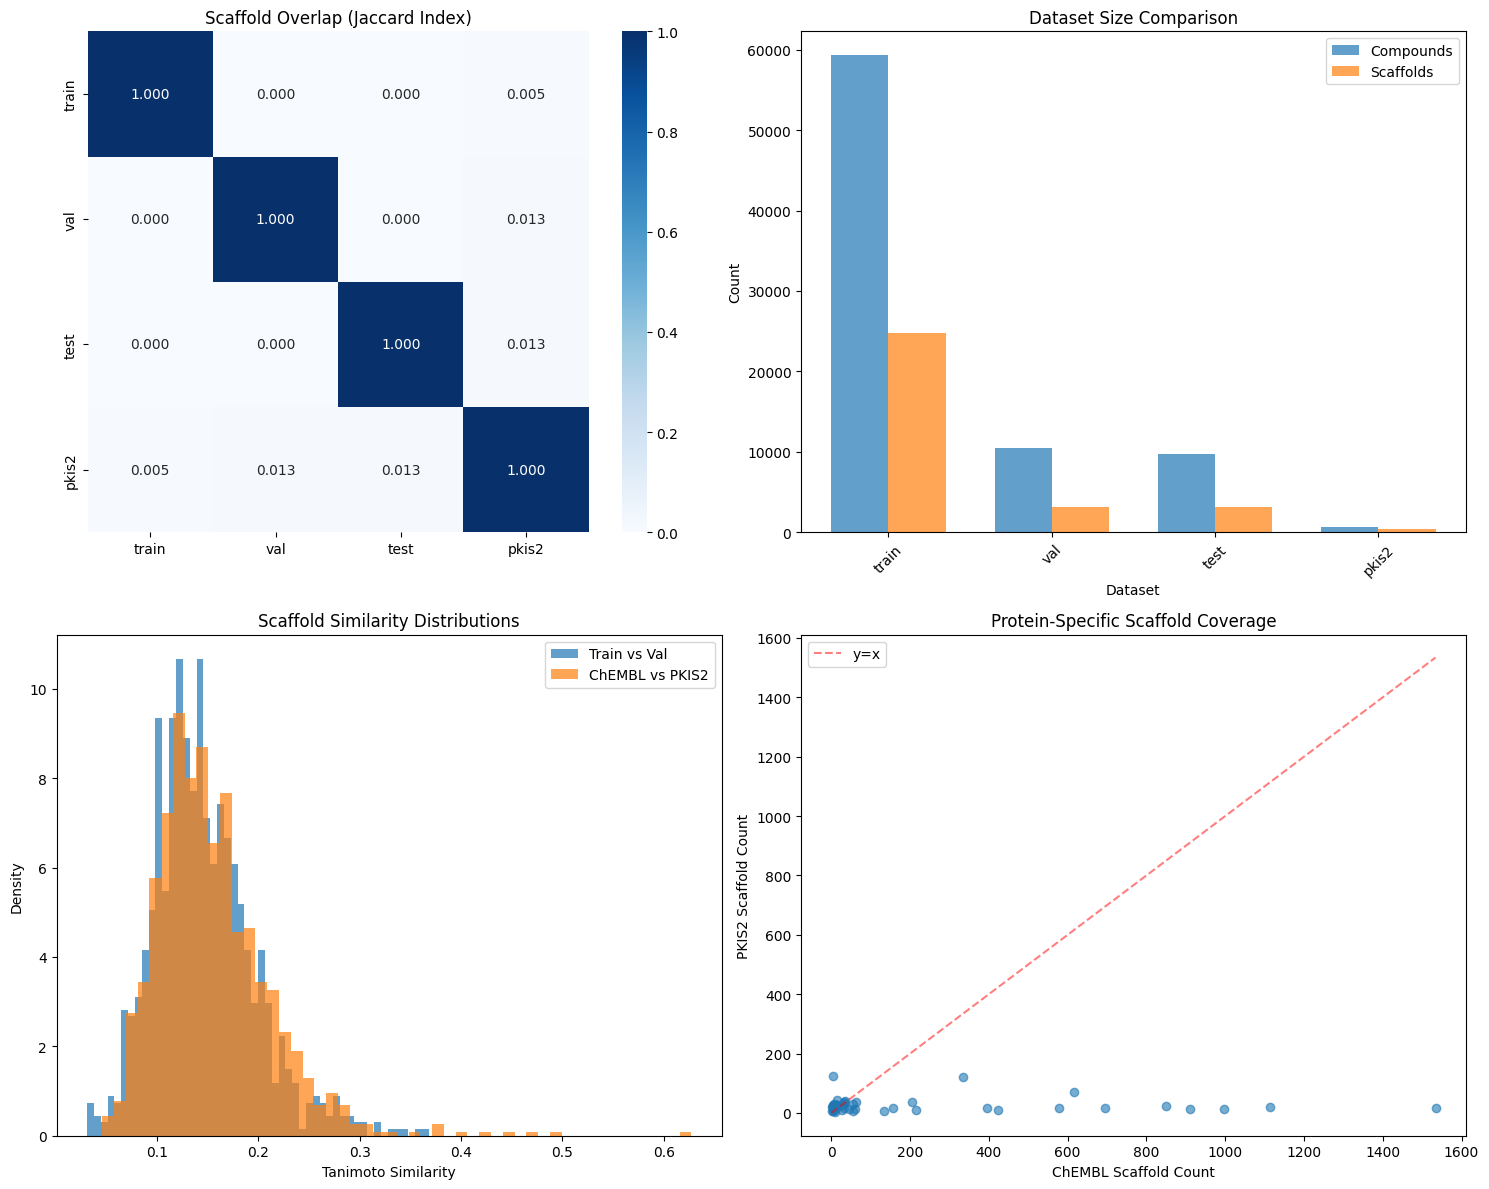

In [10]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scaffold overlap heatmap
sns.heatmap(overlap_pct_df, annot=True, fmt='.3f', cmap='Blues', 
            ax=axes[0,0], square=True)
axes[0,0].set_title('Scaffold Overlap (Jaccard Index)')

# 2. Dataset size comparison
sizes = [len(datasets[name]) for name in dataset_names]
scaffold_counts = [datasets[name]['scaffold'].nunique() for name in dataset_names]

x = np.arange(len(dataset_names))
width = 0.35

axes[0,1].bar(x - width/2, sizes, width, label='Compounds', alpha=0.7)
axes[0,1].bar(x + width/2, scaffold_counts, width, label='Scaffolds', alpha=0.7)
axes[0,1].set_xlabel('Dataset')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Dataset Size Comparison')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(dataset_names, rotation=45)
axes[0,1].legend()

# 3. Similarity distribution comparison
axes[1,0].hist(diversity_results['train_val']['similarities'], 
               bins=50, alpha=0.7, label='Train vs Val', density=True)
axes[1,0].hist(diversity_results['chembl_pkis2']['similarities'], 
               bins=50, alpha=0.7, label='ChEMBL vs PKIS2', density=True)
axes[1,0].set_xlabel('Tanimoto Similarity')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Scaffold Similarity Distributions')
axes[1,0].legend()

# 4. Protein coverage scatter
if len(final_coverage) > 0:
    x_vals = final_coverage['chembl_all_scaffold_count']
    y_vals = final_coverage['pkis2_scaffold_count']
    
    axes[1,1].scatter(x_vals, y_vals, alpha=0.6)
    axes[1,1].plot([0, max(x_vals)], [0, max(x_vals)], 'r--', alpha=0.5, label='y=x')
    axes[1,1].set_xlabel('ChEMBL Scaffold Count')
    axes[1,1].set_ylabel('PKIS2 Scaffold Count')
    axes[1,1].set_title('Protein-Specific Scaffold Coverage')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Generate summary report
print("\n" + "="*60)
print("         SCAFFOLD COVERAGE ANALYSIS SUMMARY")
print("="*60)

print(f"\n📊 DATASET OVERVIEW")
print(f"   ChEMBL Train:     {len(datasets['train']):6} compounds, {datasets['train']['scaffold'].nunique():5} scaffolds")
print(f"   ChEMBL Val:       {len(datasets['val']):6} compounds, {datasets['val']['scaffold'].nunique():5} scaffolds")
print(f"   ChEMBL Test:      {len(datasets['test']):6} compounds, {datasets['test']['scaffold'].nunique():5} scaffolds")
print(f"   PKIS2 Finetuning: {len(datasets['pkis2']):6} compounds, {datasets['pkis2']['scaffold'].nunique():5} scaffolds")

print(f"\n🔗 SCAFFOLD OVERLAP")
print(f"   Total unique scaffolds: {len(all_scaffolds)}")
print(f"   ChEMBL ∩ PKIS2: {chembl_pkis2_overlap} scaffolds ({chembl_pkis2_overlap/len(pkis2_scaffolds)*100:.1f}% of PKIS2)")
print(f"   PKIS2 unique: {pkis2_unique} scaffolds ({pkis2_unique/len(pkis2_scaffolds)*100:.1f}% of PKIS2)")

print(f"\n🧪 CHEMICAL DIVERSITY")
print(f"   ChEMBL internal similarity: {diversity_results['train_val']['mean']:.3f} ± {diversity_results['train_val']['std']:.3f}")
print(f"   ChEMBL ↔ PKIS2 similarity:  {diversity_results['chembl_pkis2']['mean']:.3f} ± {diversity_results['chembl_pkis2']['std']:.3f}")

print(f"\n🎯 PROTEIN COVERAGE")
print(f"   ChEMBL proteins: {len(chembl_proteins)}")
print(f"   PKIS2 proteins:  {len(pkis2_proteins)}")
print(f"   Shared proteins: {len(common_proteins)}")

if len(high_pkis2_coverage) > 0:
    print(f"   Proteins with higher PKIS2 diversity: {len(high_pkis2_coverage)}")
if len(low_pkis2_coverage) > 0:
    print(f"   Proteins with lower PKIS2 diversity: {len(low_pkis2_coverage)}")

print(f"\n💡 TRANSFER LEARNING INSIGHTS")
coverage_pct = chembl_pkis2_overlap / len(pkis2_scaffolds) * 100
if coverage_pct > 70:
    print(f"   ✅ EXCELLENT coverage ({coverage_pct:.1f}%) - Strong transfer learning potential")
elif coverage_pct > 50:
    print(f"   🟨 GOOD coverage ({coverage_pct:.1f}%) - Reasonable transfer learning potential")
elif coverage_pct > 30:
    print(f"   🟧 MODERATE coverage ({coverage_pct:.1f}%) - Limited transfer learning potential")
else:
    print(f"   🟥 LOW coverage ({coverage_pct:.1f}%) - Poor transfer learning potential")

novelty_pct = pkis2_unique / len(pkis2_scaffolds) * 100
print(f"   📈 PKIS2 novelty: {novelty_pct:.1f}% of scaffolds are unique to PKIS2")

print("\n" + "="*60)


         SCAFFOLD COVERAGE ANALYSIS SUMMARY

📊 DATASET OVERVIEW
   ChEMBL Train:      59311 compounds, 24749 scaffolds
   ChEMBL Val:        10467 compounds,  3093 scaffolds
   ChEMBL Test:        9703 compounds,  3093 scaffolds
   PKIS2 Finetuning:    645 compounds,   369 scaffolds

🔗 SCAFFOLD OVERLAP
   Total unique scaffolds: 31097
   ChEMBL ∩ PKIS2: 207 scaffolds (56.1% of PKIS2)
   PKIS2 unique: 162 scaffolds (43.9% of PKIS2)

🧪 CHEMICAL DIVERSITY
   ChEMBL internal similarity: 0.146 ± 0.050
   ChEMBL ↔ PKIS2 similarity:  0.155 ± 0.057

🎯 PROTEIN COVERAGE
   ChEMBL proteins: 332
   PKIS2 proteins:  356
   Shared proteins: 331
   Proteins with higher PKIS2 diversity: 26
   Proteins with lower PKIS2 diversity: 17

💡 TRANSFER LEARNING INSIGHTS
   🟨 GOOD coverage (56.1%) - Reasonable transfer learning potential
   📈 PKIS2 novelty: 43.9% of scaffolds are unique to PKIS2



In [12]:
# Save results to CSV files for further analysis
print("Saving results...")

# 1. Scaffold overlap summary
overlap_summary = pd.DataFrame({
    'Dataset_1': ['ChEMBL_All', 'ChEMBL_Train', 'ChEMBL_Val', 'ChEMBL_Test'],
    'Dataset_2': ['PKIS2', 'PKIS2', 'PKIS2', 'PKIS2'],
    'Overlap_Count': [
        len(chembl_all & pkis2_scaffolds),
        len(scaffold_sets['train'] & pkis2_scaffolds),
        len(scaffold_sets['val'] & pkis2_scaffolds),
        len(scaffold_sets['test'] & pkis2_scaffolds)
    ],
    'Jaccard_Index': [
        len(chembl_all & pkis2_scaffolds) / len(chembl_all | pkis2_scaffolds),
        overlap_pct_df.loc['train', 'pkis2'],
        overlap_pct_df.loc['val', 'pkis2'],
        overlap_pct_df.loc['test', 'pkis2']
    ]
})
overlap_summary.to_csv('scaffold_overlap_summary.csv', index=False)

# 2. Protein coverage results
if len(final_coverage) > 0:
    final_coverage.to_csv('protein_scaffold_coverage.csv', index=False)

# 3. Unique scaffolds for each dataset
unique_scaffolds = {
    'ChEMBL_Unique': list(chembl_all - pkis2_scaffolds),
    'PKIS2_Unique': list(pkis2_scaffolds - chembl_all),
    'Shared': list(chembl_all & pkis2_scaffolds)
}

# Create a comprehensive scaffold mapping
scaffold_mapping = []
for scaffold in all_scaffolds:
    row = {'scaffold': scaffold}
    for dataset_name in datasets.keys():
        row[f'in_{dataset_name}'] = scaffold in scaffold_sets[dataset_name]
    scaffold_mapping.append(row)

scaffold_mapping_df = pd.DataFrame(scaffold_mapping)
scaffold_mapping_df.to_csv('scaffold_mapping.csv', index=False)

print("✅ Analysis completed!")
print("📁 Files saved:")
print("   - scaffold_overlap_summary.csv")
print("   - protein_scaffold_coverage.csv")
print("   - scaffold_mapping.csv")

Saving results...
✅ Analysis completed!
📁 Files saved:
   - scaffold_overlap_summary.csv
   - protein_scaffold_coverage.csv
   - scaffold_mapping.csv
